$$
\begin{align*}
&\omega^2v \\
&+ 2i\omega\left( v_0\frac{\partial}{\partial z} + \frac{\partial v_0}{\partial z} \right)v \\
&+ \left[ (1-v_0^2)\frac{\partial^2}{\partial z^2} - \left(3v_0+\frac{1}{v_0}\right)\frac{\partial v_0}{\partial z}\frac{\partial}{\partial z} - \left(1-\frac{1}{v_0^2}\right)\left(\frac{\partial v_0}{\partial z}\right)^2 - \left(v_0+\frac{1}{v_0}\right)\frac{\partial^2 v_0}{\partial z^2} \right]v \\
= 0
\end{align*}
$$

In [11]:
from functions import Spectral, polyeig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_settting
from scipy.special import lambertw

W = lambda z,k: np.real(lambertw(z,k=k)) # I only need the real parts

In [34]:
def velocity_profile(M, Mm, x, constant_velocity=False,acclerting=True):
    if constant_velocity:
        v = Mm*np.ones_like(x) # constant v=0.1
        return v

    if Mm < 1:
        v = M(x, Mm=Mm, k=0) # subsonic velocity profile, M_m = 0.1
    elif Mm == 1:
        if method == "FD":
            if acclerting:
                v = np.concatenate([M(x[x<0], Mm=1, k=0), [1], M(x[x>0], Mm=1, k=-1)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x<0], Mm=1, k=-1), [1], M(x[x>0], Mm=1, k=0)]) # decelerating velocity profile
        elif method == "CH":
            if acclerting:
                v = np.concatenate([M(x[x>0], Mm=1, k=-1), M(x[x<0], Mm=1, k=0)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x>0], Mm=1, k=0), M(x[x<0], Mm=1, k=-1)]) # decelerating velocity profile
    else:
        v = M(x, Mm=Mm, k=-1) # supersonic velocity profile
    return v

def select_solutions(V,omega, omega_real_range=[0,100], omega_imag_range=None):
    selection = (np.real(omega) > omega_real_range[0]) & (np.real(omega) < omega_real_range[1])
    if omega_imag_range:
        selection = selection & (np.imag(omega) > omega_imag_range[0]) & (np.imag(omega) < omega_imag_range[1])
    return V[:,selection], omega[selection]

def sort_solutions(V,omega):
    index = np.argsort(omega)
    V = V[:,index]
    omega = omega[index]
    return V, omega

def plotting(V,omega, num_eigfuncs=5):
    plt.figure()
    plt.plot(x, v0)
    plt.title(f"Velocity profile $M_m={Mm}$")
    plt.xlabel("$z$")
    plt.ylabel("$v$");

    plt.figure()
    plt.plot(np.real(omega), np.imag(omega), 'o')
    plt.xlabel("$\Re(\omega)$")
    plt.ylabel("$\Im(\omega)$")
    plt.title(f"eigenvalues, $M_m={Mm}$")

    plt.figure()
    for i in range(num_eigfuncs):
        v = V[:,i]
        plt.plot(x, np.real(v), '-', color=f"C{i}", label=f"$\omega={omega[i]}$")
        plt.plot(x, np.imag(v), '--', color=f"C{i}")
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"eigenfunctions, $M_m={Mm}$")
    plt.legend()

In [35]:
# domain information
N = 101 # 200 cells
domain = "symmetric"
method = "FD"
spectral = Spectral(N,domain,method)

# magnetic field, B, and velocity profile, M
B0 = 1
R = 1.5
Bm = 1+R
Delta = 0.1/0.3
B = lambda z: B0*(1+R*np.exp(-(z/Delta)**2))

# k=-1: supersonic branch
# k=0: subsonic branch
M = lambda z, Mm, k: np.sqrt( -W(-Mm**2 * (B(z)/Bm)**2 * np.exp(-Mm**2), k=k) )

x = spectral.x
Mm = 1.1
acclerting = False
constant_velocity = False
v0 = velocity_profile(M,Mm,x,constant_velocity,acclerting)

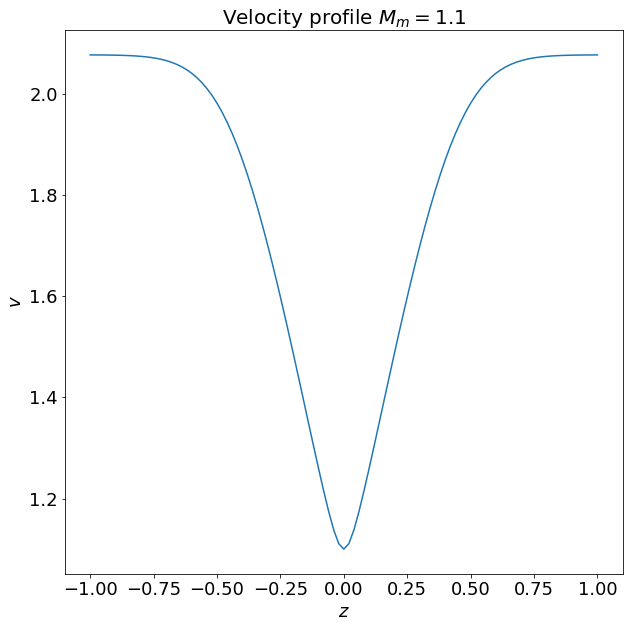

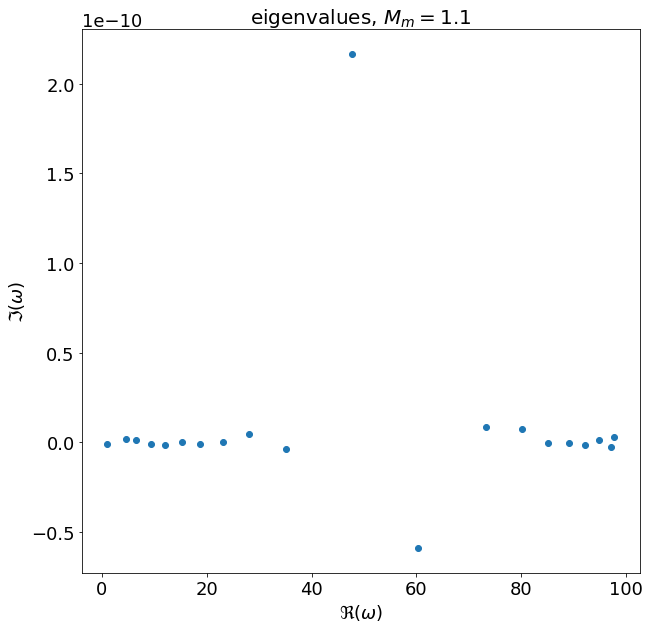

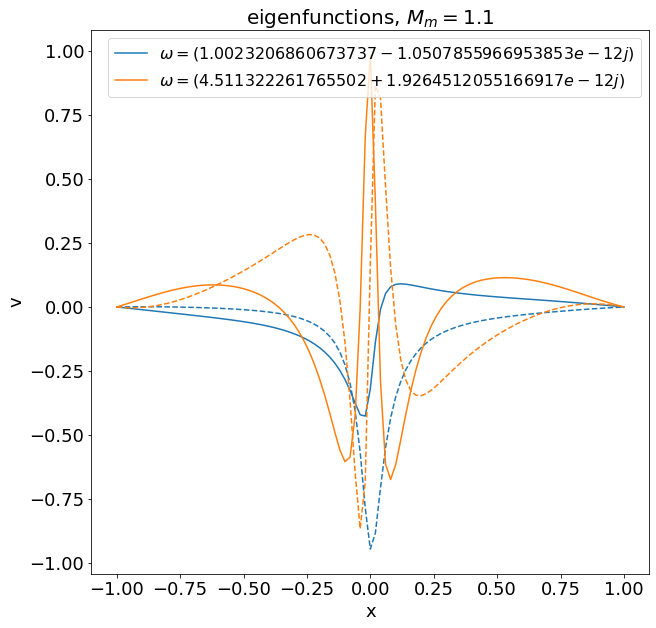

In [39]:
# differentiation matrices
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
I = np.eye(*D1.shape)

# matrices for polynomial eigenvalue problem
A2 = I
A1 = 2j*(np.diag(v0)@D1 + np.diag(D1@v0))
A0 = np.diag(1-v0**2)@D2 \
    - np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
    - np.diag((1-1/v0**2)*(D1@v0)**2) \
    - np.diag((v0+1/v0)*(D2@v0))

# remove boundaries because derivatives behave bad there
A2 = A2[1:-1,1:-1]
A1 = A1[1:-1,1:-1]
A0 = A0[1:-1,1:-1]

# eigenvectors, eigenvalues
V, omega = polyeig(A0, A1, A2)
V = np.pad(V, ((1,1),(0,0)), 'constant', constant_values=0)

V,omega = select_solutions(V,omega,omega_real_range=[0,100], omega_imag_range=[-1,1])
V,omega = sort_solutions(V,omega)
plotting(V,omega,num_eigfuncs=2)